### Apple Leaf Health Status Using CNNs

Given a photo of an apple leaf, the notebook predicts which of the 4 classes the leaf belongs to. This is a Kaggle competition dataset and  there are no labels for the Test set. So, the training dataset will be split into Train and Validation sets. The challenge is to distinguish between leaves which are <b>healthy</b>, those which are infected with <b>apple rust</b>, those that have <b>apple scab</b>, and those with <b>more than one disease</b>.

Automated monitoring through installation of cameras in the Apple orchards can help focus on the plants which actually needs attention. Farmers can then decide on the treatment with chemicals for resolution.

https://www.kaggle.com/competitions/plant-pathology-2020-fgvc7/data

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
import torch
import torchvision
import torchvision.transforms as tt
import torch.nn as nn
import torch.nn.functional as F

#Torchvision Utilities
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split

In [10]:
import shutil
import os
from shutil import copyfile

In [1]:
PATH = 'C:/Users/dhema/Documents/plant-pathology-2020-fgvc7'

In [11]:

df_csv = pd.read_csv(PATH+'/train.csv')
df_csv.columns

Index(['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')

In [12]:
labels = df_csv.columns[1:].tolist()
labels

['healthy', 'multiple_diseases', 'rust', 'scab']

### Class Distribution

- The dataset contains <b>1856</b> samples and each leaf falls under one of the four categories.

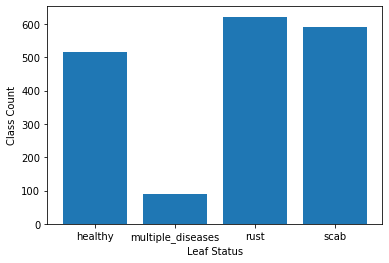

In [13]:
img_count = {}
for cls in labels:
    img_count[cls] = df_csv[cls].sum()
plt.bar(img_count.keys(), img_count.values())
plt.xlabel('Leaf Status')
plt.ylabel('Class Count')
plt.show()

### Directory Strucutre Creation

- Originally we have two data sets available, <b>Train (1856 labled Samples)</b> and <b>Unlabled Test set</b> folder.

Because the Test set is unlabled, I have used only the training set for both training and evaluation.

We have all the 4 classes of images in one directory and a csv file which contains the image_id and the category that image belong to. The below cells takes all the images in Train folder and copies them into 4 folders each belonging to one specific class

In [14]:
### Training Directory
os.mkdir('./train')
os.mkdir('./train/healthy')
os.mkdir('./train/multiple_diseases')
os.mkdir('./train/rust')
os.mkdir('./train/scab')

In [15]:
### Validation Directory
os.mkdir('./validation')
os.mkdir('./validation/healthy')
os.mkdir('./validation/multiple_diseases')
os.mkdir('./validation/rust')
os.mkdir('./validation/scab')

In [16]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(df_csv, test_size = 0.2, random_state = 42)
train.head()

,image_id,healthy,multiple_diseases,rust,scab
1455,Train_1455,0,0,1,0
1552,Train_1552,1,0,0,0
300,Train_300,1,0,0,0
1708,Train_1708,0,1,0,0
611,Train_611,0,0,1,0


In [17]:
# Copy the images into their respective directories
src = 'C:/Users/dhema/Documents/Mannheim/FSS2022/AI In Industry/Project Portfolio/Primary/plant-pathology-2020-fgvc7/images'
train_dir = 'C:/Users/dhema/Documents/Mannheim/FSS2022/AI In Industry/Project Portfolio/Primary/train'
valid_dir = 'C:/Users/dhema/Documents/Mannheim/FSS2022/AI In Industry/Project Portfolio/Primary/validation'

In [18]:
# Training Set
for _, row in train.iterrows():
    label =labels[np.argmax(row[1:])]
    #print(row[0], '--',label)
    file = os.path.join(src,row[0]+'.jpg')
    dest = os.path.join(train_dir,label,row[0]+'.jpg')
    copyfile(file,dest)
    
# Validation Set

for _, row in valid.iterrows():
    label =labels[np.argmax(row[1:])]
    #print(row[0], '--',label)
    file = os.path.join(src,row[0]+'.jpg')
    dest = os.path.join(valid_dir,label,row[0]+'.jpg')
    copyfile(file,dest)
    

In [19]:
dataset = ImageFolder(train_dir,transform=ToTensor())

In [20]:
Classes = dataset.classes

In [21]:
img, label = dataset[10]

print('Shape', img.shape)
print('Label', Classes[label])
print('Label No. ', label)

Shape torch.Size([3, 1365, 2048])
Label healthy
Label No.  0


### Sample Images

In [22]:
def show_image(image, label):
    print('Shape : ', img.shape)
    print('Label : ', Classes[label])
    # The image is of shape 3x1365x2048 and plt.imshow expects the color channel to be the last dimension. Permute method helps reshape
    plt.imshow(image.permute(1,2,0))

Shape :  torch.Size([3, 1365, 2048])
Label :  healthy


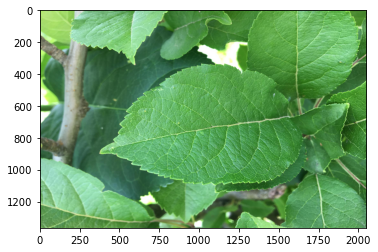

In [23]:
show_image(*dataset[10])

Shape :  torch.Size([3, 1365, 2048])
Label :  scab


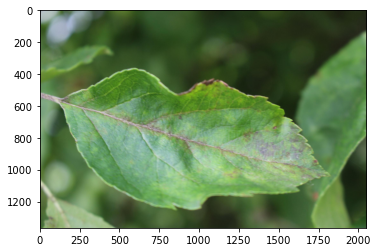

In [24]:
show_image(*dataset[1000])

In [25]:
# set random seed

random_seed = 42
torch.manual_seed(random_seed)

In [26]:
dataset[1000]

(tensor([[[0.2667, 0.2824, 0.3059,  ..., 0.1255, 0.1255, 0.1255],
          [0.2824, 0.2980, 0.3216,  ..., 0.1255, 0.1255, 0.1255],
          [0.3059, 0.3255, 0.3529,  ..., 0.1255, 0.1255, 0.1255],
          ...,
          [0.2784, 0.2784, 0.2745,  ..., 0.2196, 0.2196, 0.2235],
          [0.2745, 0.2745, 0.2745,  ..., 0.2196, 0.2196, 0.2196],
          [0.2745, 0.2745, 0.2706,  ..., 0.2196, 0.2196, 0.2196]],
 
         [[0.3490, 0.3608, 0.3843,  ..., 0.1608, 0.1608, 0.1608],
          [0.3608, 0.3765, 0.4000,  ..., 0.1608, 0.1608, 0.1608],
          [0.3843, 0.4039, 0.4314,  ..., 0.1608, 0.1608, 0.1608],
          ...,
          [0.3922, 0.3922, 0.3922,  ..., 0.3843, 0.3843, 0.3882],
          [0.3882, 0.3882, 0.3922,  ..., 0.3843, 0.3843, 0.3843],
          [0.3882, 0.3882, 0.3882,  ..., 0.3843, 0.3843, 0.3843]],
 
         [[0.3294, 0.3529, 0.3804,  ..., 0.0784, 0.0784, 0.0784],
          [0.3529, 0.3686, 0.3961,  ..., 0.0784, 0.0784, 0.0784],
          [0.3804, 0.4000, 0.4353,  ...,

## Data Augmentation & Normalization

In [27]:
#chanel wise data Normalization

def get_mean_std(dataset):
    # create batches of data
    data_loader = DataLoader(dataset,batch_size = 1)
    
    channel_sum, channel_squared_sum, num_batches = 0, 0, 0
    #loop to process data in batches
    for data,_ in data_loader:
        channel_sum += torch.mean(data, dim = [0,2,3])
        channel_squared_sum += torch.mean(data**2, dim = [0, 2, 3])
        num_batches +=1
  
    # VAR[X] = E[X**2] - E[X]**2
    # STD[X] = sqrt(VAR[X])

    mean = channel_sum/num_batches
    std = (channel_squared_sum/num_batches-mean**2)**0.5
    # transform to numpy array
    mean = mean.numpy()
    std = std.numpy()
    return mean, std


In [15]:
#get_mean_std(dataset)

- Calculating the mean and standard deviation of each channel takes a lot of time. When the batch size was increased it was giving memory/dataset errors. Hence after one successful run with batch size = 1, the metrics were calculated and kept for future use and the above cell was commented.

array([0.4018925 , 0.5119272 , 0.31237948], dtype=float32),
array([0.20609608, 0.1910669 , 0.18972935], dtype=float32))

In [28]:
stat = ((0.4018925 , 0.5119272 , 0.31237948),(0.20609608, 0.1910669 , 0.18972935))

- Each image is of shape 3x1365x2048 (3 channel image). The below transformation resizes the image into 3x128x128 shape for faster training.

In [29]:
# Transformations for Dataset (Augmentation & Normalization)

train_tfms = tt.Compose([tt.Resize((128,128)),
                         #tt.RandomCrop(224),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stat, inplace=True)
                         ])

valid_tfms = tt.Compose([tt.Resize((128,128)),tt.ToTensor(), tt.Normalize(*stat, inplace=True)
])

In [30]:
# data is now stored to ImageFolder instances after the above transformations
training_data = ImageFolder(train_dir,train_tfms)
validation_data = ImageFolder(valid_dir,valid_tfms)

In [31]:
batch_size = 16

In [32]:
# data loaders for consuming batches of data
train_dl = DataLoader(training_data, batch_size=batch_size, shuffle=True,num_workers=2, pin_memory=True)
valid_dl = DataLoader(validation_data, batch_size=batch_size, num_workers=2, pin_memory=True)

In [37]:
# Normalized Images
# Print the batch of images

def print_batch(dataloader):
    for batch_images, bacth_labels in dataloader:

        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(batch_images[:30], nrow = 8).permute(1,2,0))
        break


In [34]:
for batch_images, bacth_labels in train_dl:
    print(batch_images.shape)
    break

torch.Size([16, 3, 128, 128])


In [35]:
for batch_images, bacth_labels in valid_dl:
    print(batch_images.shape)
    break

torch.Size([16, 3, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


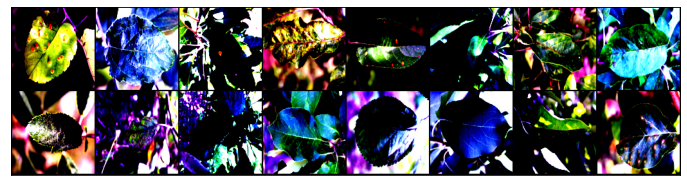

In [38]:
print_batch(train_dl)
    
    

### ImageClassification Base Class

- The class contains generic training/validations steps to calculate training & validation losses. It also has functions to store epoch losses and accuracies. 

In [39]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

### Custom extension Class

In [40]:
class AppleLeafHealth(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 32 x 64 x 64
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 16 x 16
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 2 x 2
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2), # output: 1024 x 1 x 1
            
            nn.Flatten(), 
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 4))
        
    def forward(self, xb):
        return self.network(xb)
    

### Custom RestNet9 class

- This class extends the ImageClassificationBase class created earlier. 

In [41]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input 3x128x128
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True) # 128x64x64
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True) # 256x32x32
        self.conv4 = conv_block(256, 512, pool=True) # 512x16x16
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.conv5 = conv_block(512, 1024, pool=True) # 1024x8x8
        self.conv6 = conv_block(1024, 1024, pool=True) # 1024x4x4
        self.conv7 = conv_block(1024, 1024, pool=True) # 1024x2x2
        
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(1024, 512),
                                        nn.ReLU(),
                                        #nn.Linear(512, 256),
                                        #nn.ReLU(),
                                        #nn.Linear(256, 64),
                                        #nn.ReLU(),
                                        #nn.Linear(64, 16),
                                        #nn.ReLU(),
                                        nn.Linear(512, num_classes))
                                        
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.conv7(out) 
        out = self.classifier(out)
        return out

### Device Selection(CPU/GPU)

These helper functions & classes will help to move the data and models from storage onto a GPU RAM(if available) for training

In [42]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [44]:
device = get_default_device()
device

device(type='cpu')

#### Resnet Model Initialization

In [46]:
model = to_device(ResNet9(3, 4), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

#### Movind batches of images(data loader instances) onto GPU/CPU memories

In [47]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
to_device(model, device);

In [48]:
for images, labels in train_dl:
    print('images shape',images.shape)
    out = model(images)
    print('out shape', out.shape)
    print(out)
    
    break

images shape torch.Size([16, 3, 128, 128])
out shape torch.Size([16, 4])
tensor([[ 0.0966,  0.5649, -0.3775, -0.0784],
        [ 0.0132,  0.2374, -0.3852, -0.5141],
        [ 0.5981,  0.2074, -0.5905, -0.6824],
        [ 0.2548,  0.2469, -0.2660, -0.5300],
        [ 0.4724,  0.4924, -0.3358, -0.3765],
        [-0.0698,  0.6935, -0.8521,  0.1527],
        [-0.2385,  0.7959, -0.6160, -0.0145],
        [ 0.2972,  0.4828, -0.2903,  0.0896],
        [-0.2280,  0.4678, -0.8032, -0.3646],
        [ 0.3249,  0.5034, -0.3298, -0.7718],
        [ 0.6811,  0.4987, -0.1192, -0.3496],
        [ 0.3194,  0.4651, -0.6331, -0.2409],
        [ 0.5077,  0.4640, -0.4763, -0.9092],
        [ 0.3002,  0.2784, -0.9128, -0.5133],
        [ 0.6382,  0.3286, -0.3545,  0.0302],
        [ 0.1035,  0.2737, -0.1790, -0.1613]], grad_fn=<AddmmBackward0>)


- The above step shows each batch consists of 16 images with 128x128 pixels and the output is of shape 16x4

### Model Training

- The training uses <b>one cycle learning rate policy</b> with SGD as the default optimization function

In [49]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [50]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.4008694887161255, 'val_acc': 0.04891304299235344}]

In [35]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [36]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00392, train_loss: 1.6924, val_loss: 1.5965, val_acc: 0.2673
Epoch [1], last_lr: 0.00935, train_loss: 2.5207, val_loss: 64.3324, val_acc: 0.2500
Epoch [2], last_lr: 0.00972, train_loss: 2.0963, val_loss: 1.2392, val_acc: 0.3315
Epoch [3], last_lr: 0.00812, train_loss: 1.3038, val_loss: 1.2796, val_acc: 0.3194
Epoch [4], last_lr: 0.00556, train_loss: 1.2591, val_loss: 1.2243, val_acc: 0.3430
Epoch [5], last_lr: 0.00283, train_loss: 1.2560, val_loss: 1.2037, val_acc: 0.4036
Epoch [6], last_lr: 0.00077, train_loss: 1.2272, val_loss: 1.1871, val_acc: 0.4179
Epoch [7], last_lr: 0.00000, train_loss: 1.1928, val_loss: 1.1633, val_acc: 0.4362
CPU times: user 1min 11s, sys: 39.1 s, total: 1min 50s
Wall time: 11min 52s


In [37]:
epochs = 30

In [38]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00068, train_loss: 1.2036, val_loss: 1.1848, val_acc: 0.4237
Epoch [1], last_lr: 0.00151, train_loss: 1.2155, val_loss: 1.2339, val_acc: 0.3917
Epoch [2], last_lr: 0.00279, train_loss: 1.2605, val_loss: 1.2060, val_acc: 0.3315
Epoch [3], last_lr: 0.00436, train_loss: 1.3209, val_loss: 1.3358, val_acc: 0.3890
Epoch [4], last_lr: 0.00603, train_loss: 1.3767, val_loss: 1.2406, val_acc: 0.3315
Epoch [5], last_lr: 0.00759, train_loss: 1.2822, val_loss: 1.8720, val_acc: 0.3614
Epoch [6], last_lr: 0.00887, train_loss: 1.2454, val_loss: 1.1948, val_acc: 0.3742
Epoch [7], last_lr: 0.00971, train_loss: 1.2284, val_loss: 1.2503, val_acc: 0.3315
Epoch [8], last_lr: 0.01000, train_loss: 1.2503, val_loss: 1.2250, val_acc: 0.3315
Epoch [9], last_lr: 0.00994, train_loss: 1.2472, val_loss: 1.2512, val_acc: 0.3344
Epoch [10], last_lr: 0.00978, train_loss: 1.2519, val_loss: 1.4927, val_acc: 0.3207
Epoch [11], last_lr: 0.00950, train_loss: 1.2533, val_loss: 1.2273, val_acc: 0.3577
Ep

### Saving Model

In [39]:
torch.save(model.state_dict(), 'AppleLeafHealth-ResNet09.pth')

### Accuracy & Loss Plots

In [40]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

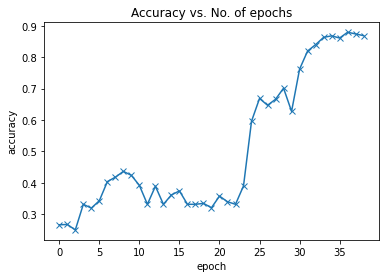

In [41]:
plot_accuracies(history)

- The model achieves a fair validation accuracy of 90% in 38 epochs.

In [42]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

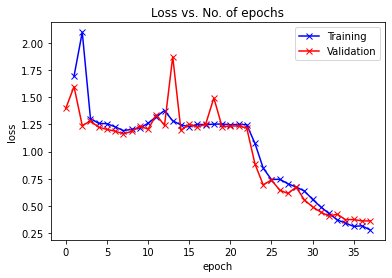

In [49]:
train_losses = [x.get('train_loss') for x in history]
train_losses.pop(2)
val_losses = [x['val_loss'] for x in history]
val_losses.pop(2)
plt.plot(train_losses, '-bx')
plt.plot(val_losses, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs');

### Learning Rate Vs Batch

In [50]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

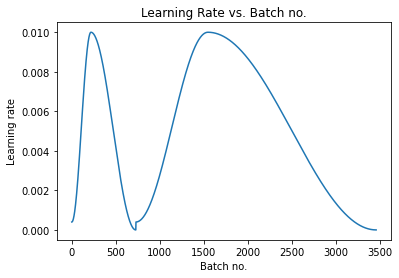

In [51]:
plot_lrs(history)

### Prediction

#### The below cell is for the Tutor to load and test the model

In [ ]:
#model2 = to_device(ResNet9(3, 4), device)
#model2.load_state_dict(torch.load('AppleLeafHealth-ResNet09.pth'))

In [52]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return training_data.classes[preds[0].item()]

Label: healthy , Predicted: healthy


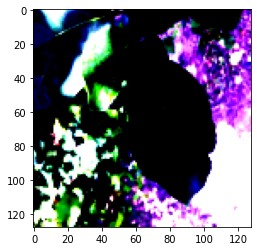

In [53]:
img, lab = validation_data[33]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('Label:', training_data.classes[lab], ', Predicted:', predict_image(img, model))


Label: rust , Predicted: rust


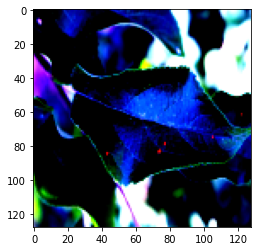

In [54]:
img, lab = validation_data[120]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('Label:', training_data.classes[lab], ', Predicted:', predict_image(img, model))

### Baseline Model

- This model was created as a baseline and it had very <b>dismal accuracy of 33%</b>

In [63]:
model_AL = to_device(AppleLeafHealth(), device)
model_AL

AppleLeafHealth(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [58]:
epochs_AL = 50
opt_funct = torch.optim.Adam
lr_AL =0.001

In [79]:
#fit
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            lrs.append(0.00)
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs']=lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [80]:
history_AL = [evaluate(model_AL, valid_dl)]
history_AL

[{'val_acc': 0.3586956560611725, 'val_loss': 1.2261855602264404}]

In [ ]:
%%time
import time
start_time = time.time()
history_AL += fit(epochs_AL,lr_AL,model_AL,train_dl,valid_dl,opt_funct)
end_time = time.time()

Epoch [0], last_lr: 0.00000, train_loss: 1.2515, val_loss: 1.2254, val_acc: 0.3315
Epoch [1], last_lr: 0.00000, train_loss: 1.2504, val_loss: 1.2363, val_acc: 0.3315
Epoch [2], last_lr: 0.00000, train_loss: 1.2509, val_loss: 1.2282, val_acc: 0.3315
Epoch [3], last_lr: 0.00000, train_loss: 1.2461, val_loss: 1.2263, val_acc: 0.3587
Epoch [4], last_lr: 0.00000, train_loss: 1.2476, val_loss: 1.2263, val_acc: 0.3315
Epoch [5], last_lr: 0.00000, train_loss: 1.2456, val_loss: 1.2295, val_acc: 0.3315
Epoch [6], last_lr: 0.00000, train_loss: 1.2468, val_loss: 1.2263, val_acc: 0.3315
Epoch [7], last_lr: 0.00000, train_loss: 1.2472, val_loss: 1.2347, val_acc: 0.3315
Epoch [8], last_lr: 0.00000, train_loss: 1.2478, val_loss: 1.2297, val_acc: 0.3315
Epoch [9], last_lr: 0.00000, train_loss: 1.2460, val_loss: 1.2263, val_acc: 0.3315
Epoch [10], last_lr: 0.00000, train_loss: 1.2468, val_loss: 1.2413, val_acc: 0.3315
Epoch [11], last_lr: 0.00000, train_loss: 1.2483, val_loss: 1.2308, val_acc: 0.3315
Ep

### Experiment History & Summary

Training deep convolutional neural networks with high quality images and complex networks is resource and time intensive. I have experimented the below techniques to achieve a model with good accuracy and reduced training time.

The <b>AppleLeafHealth-ResNet09.pth</b> model gaved the best validation accuracy(90%) of all the models trained and tested. Differet hyperparameters such as image size, learning rate, number of layers, activation functions, optimizers were tried and tested.

<b>Data Normalization</b> The appleaf images are mostly dominated by green color and the pixel values from this channel can disproportionately impact the losses and gradients. This was overcome by subtracting the mean and dividing from the pixel values before dividing them with respective channel standard deviations.

<b>Data Augmentation</b> Due to small dataset size, random transformations were applied whihc helps the network in better training.

<b>Image Pixels and Batche size</b>: I have trained the models on 256x256 pixels, 224x224 and 128x128 pixels. The <b>128x128</b> pixel images with <b>16 batches</b> showed best performance in terms of resource consumption and training time. Large batches often showed out of memory errors even on Google colab GPUs.

<b>Optimizer & Learning Rate</b>: Adam optimizer with One cycle learning rate policy broke the 33% accuracy barrier and achieved best <b>validation accuracy of 90%</b> among all the experiments carried out.

<b>Convolution Layer</b>: ResNet architecture was used with convolution layers (upto 1024 kernels), <b>Maxpooling layers</b> and drop out layers. I have also used <b> batch normalization</b> and <b>ReLU</b> as the activation function.

<b>Fully Connected Layers(FCN)</b> Deep FCNs with 5 layers have took a lot of time when compared with just 2 FCN layers1024-->512-->4). Also deep FCNs did not guarantee better validation accuracy although training accuracy was good.


### Further Improvements

The below techniques can further be applied along with running the model on a GPU will certainly improve the run time.

<b>Transfer learning</b> can be used for faster training and to check whether complex networks can really improve the accuracy with the dataset at hand. Also, the apple leaf dataset is small for a CNN project and it can be the reason for the poor performance.